## Kaggle Retinal Lesions Segmentation

### Train labels

 Loading the dataset

In [174]:
from sklearn.model_selection import train_test_split
from shutil import copy, unpack_archive

import matplotlib.pyplot as plt
import pandas as pd
import progressbar
import os

In [175]:
def reset_path(directory:str):
    """
    Deletes an existing directory and re-creates it

    - directory: path to directory
    """
    if os.path.exists(directory):
        !rm -r {directory}
    os.mkdir(directory)

In [176]:
DS_BASE_PATH = 'Data'
DB_PATH = 'DB'
reset_path(DB_PATH)

In [177]:
filename = 'retinal-lesions-v20191227'
ARCHIVE_FILE_PATH = os.path.join(DS_BASE_PATH, f'{filename}.zip')

if not os.path.exists(os.path.join(DS_BASE_PATH, f'{filename}')):
    unpack_archive(ARCHIVE_FILE_PATH, DS_BASE_PATH)

grading_csv_path = os.path.sep.join([DS_BASE_PATH,f'{filename}' ,'dr_grades.csv'])
grading_orig = pd.read_csv(grading_csv_path)
grading_orig.dropna()

segmentation_csv_path = os.path.sep.join([DS_BASE_PATH,f'{filename}' ,'segmentation_metadata.csv'])
segmentation_orig = pd.read_csv(segmentation_csv_path)
segmentation_orig.dropna()

display(grading_orig)
display(segmentation_orig)

,image id,kaggle label,our label
0,7384_right,2,2
1,27099_left,3,2
2,25531_right,2,2
3,34701_right,2,2
4,3166_right,2,1
...,...,...,...
1588,26615_right,2,2
1589,30283_left,2,2
1590,16602_right,2,1
1591,42897_left,2,2


,name,microaneurysm,retinal_hemorrhage,hard_exudate,cotton_wool_spots,neovascularization,vitreous_hemorrhage,preretinal_hemorrhage,fibrous_proliferation
0,10037_left,1,1,0,0,0,0,0,0
1,10047_right,1,1,1,0,0,0,0,0
2,1008_right,1,1,1,1,0,0,0,0
3,10091_right,1,1,1,0,0,0,0,0
4,10105_right,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1570,9893_right,1,1,1,0,0,0,0,0
1571,9944_left,1,0,0,0,0,0,0,0
1572,9990_right,1,1,0,0,0,0,0,0
1573,99_right,1,1,1,0,0,0,0,0


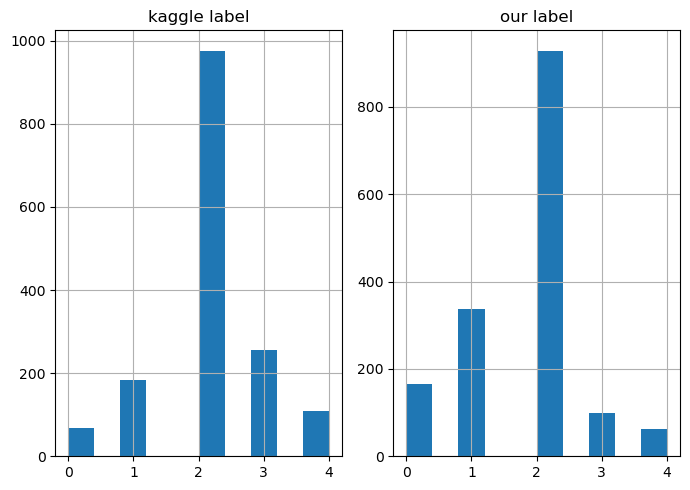

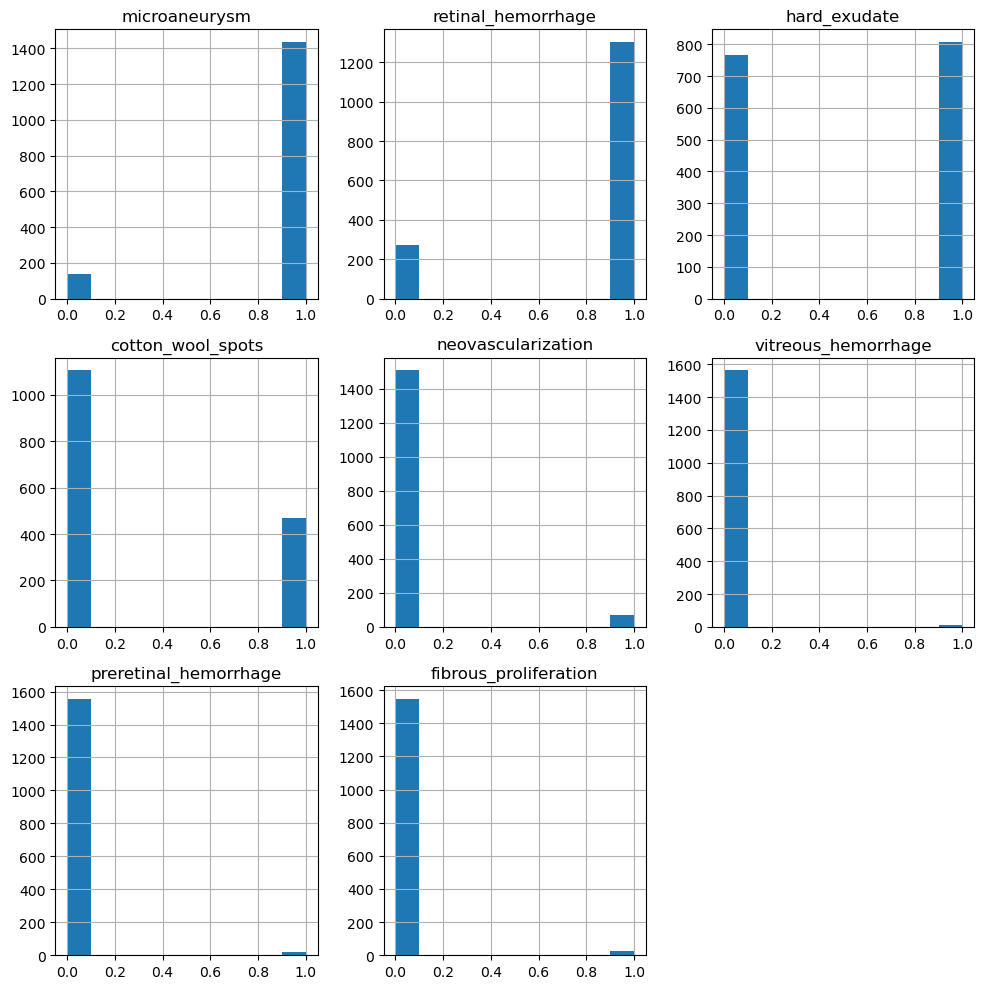

neovascularization
0    1507
1      68
Name: neovascularization, dtype: int64
vitreous_hemorrhage
0    1562
1      13
Name: vitreous_hemorrhage, dtype: int64
preretinal_hemorrhage
0    1556
1      19
Name: preretinal_hemorrhage, dtype: int64
fibrous_proliferation
0    1547
1      28
Name: fibrous_proliferation, dtype: int64


In [178]:
for df, fsize in zip([grading_orig, segmentation_orig], [(7,5), (10,10)]):
    df.hist(figsize = fsize)
    plt.tight_layout()
    plt.show()

keys = list(segmentation_orig.keys())
for category in keys[5:]:
    print(category)
    print(df[category].value_counts())

Sampling ```segmentation_orig```

Sampled Segmentation Dataset


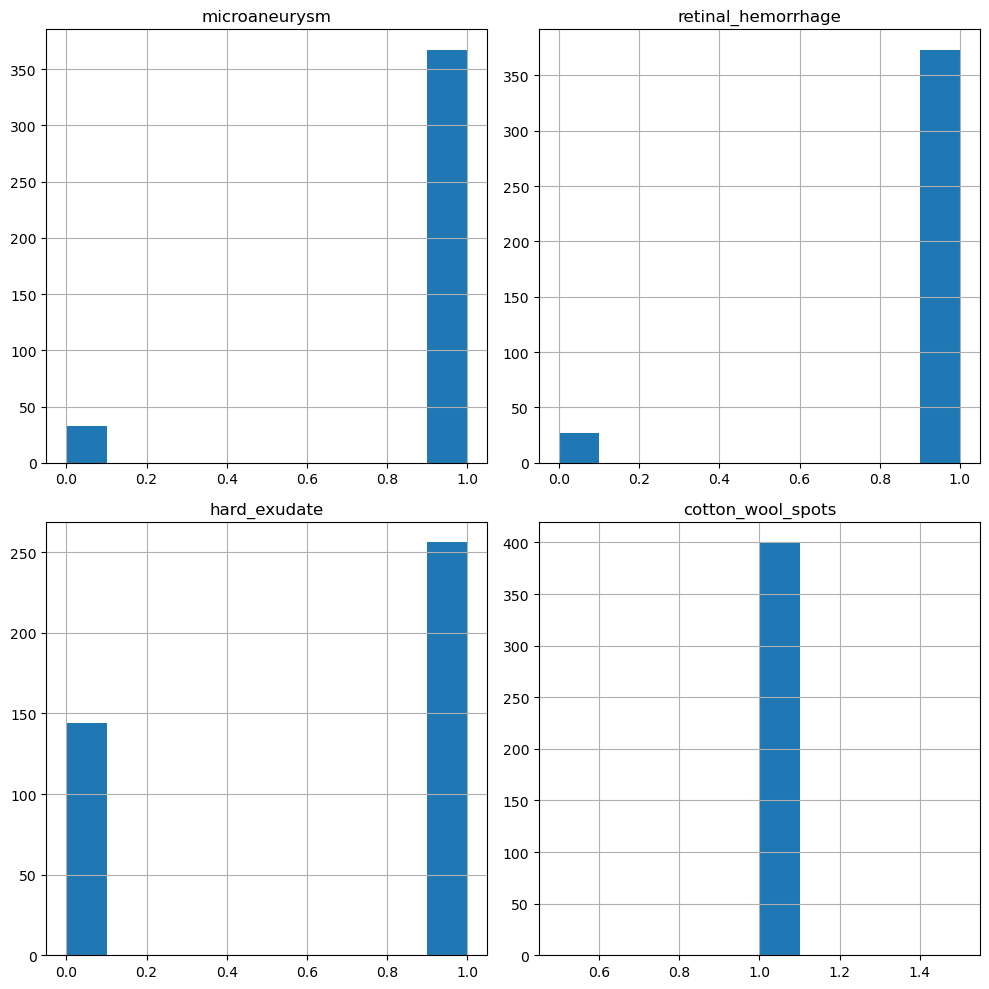

Elements not in the sample


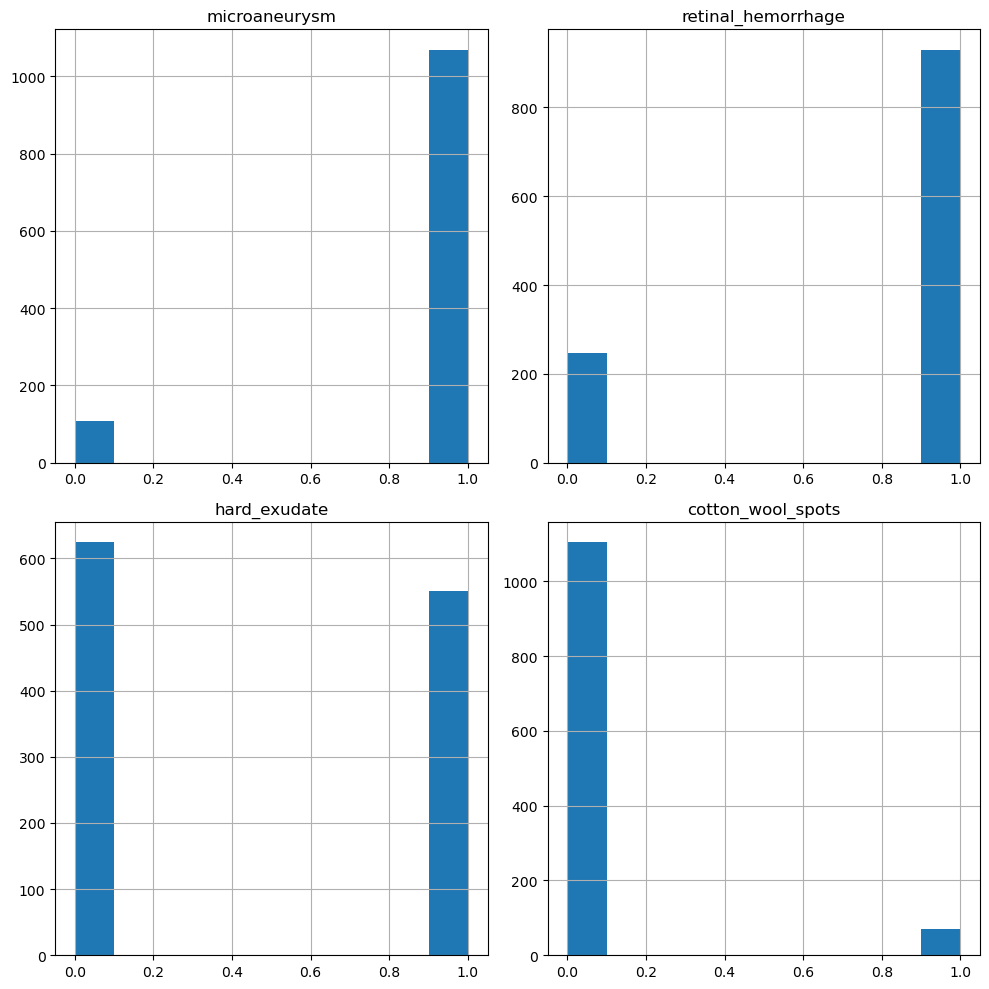

microaneurysm
1    1068
0     107
Name: microaneurysm, dtype: int64

retinal_hemorrhage
1    929
0    246
Name: retinal_hemorrhage, dtype: int64

hard_exudate
0    624
1    551
Name: hard_exudate, dtype: int64

cotton_wool_spots
0    1104
1      71
Name: cotton_wool_spots, dtype: int64



In [179]:
segmentation_orig.drop(columns= segmentation_orig.columns[5:], inplace=True) # segmentation_orig.columns[5:]
segmentation_orig.head()

segmentation_sampled = segmentation_orig.sample(
    n = 400,
    # replace=True,
    weights='cotton_wool_spots'
    )

rest_df = segmentation_orig.loc[~segmentation_orig['name'].isin(segmentation_sampled['name'])].dropna()

for df, title in zip([segmentation_sampled, rest_df], ['Sampled Segmentation Dataset', 'Elements not in the sample']):
    df.hist(figsize = fsize)
    print(f'{title}')
    plt.tight_layout()
    plt.show()

keys = list(rest_df.keys())
for category in keys[1:]:
    print(category)
    print(rest_df[category].value_counts(),end='\n\n')

Dividing __train/val/test/rest__

In [180]:
x_train, x_remain, _, _ = train_test_split(
    segmentation_sampled['name'],
    segmentation_sampled,
    train_size=0.7,
    test_size=0.3,
    random_state=42
)

In [181]:
train_df = pd.DataFrame()
train_df['name'] = x_train

remain_df = pd.DataFrame()
remain_df['name'] = x_remain

In [182]:
x_val, x_test, _, _ = train_test_split(
    remain_df['name'],
    remain_df,
    train_size=0.5,
    test_size=0.5,
    random_state=42
)

In [183]:
val_df = pd.DataFrame()
val_df['name'] = x_val

test_df = pd.DataFrame()
test_df['name'] = x_test

In [184]:
assert train_df['name'].count() + val_df['name'].count() + test_df['name'].count() + rest_df['name'].count() == segmentation_orig['name'].count()

print(f"Training: {train_df['name'].count()}; Validation: {val_df['name'].count()}; Test: {test_df['name'].count()}; Rest: {rest_df['name'].count()}")

Training: 280; Validation: 60; Test: 60; Rest: 1175


In [185]:
# def create_path(base_dir:str, dir_name:str):
#     directory = os.path.sep.join([base_dir, dir_name])
#     """
#     Creates a new directory if it doesn't exist already

#     - dir_name: path to directory
#     """
#     if not os.path.exists(directory):
#         os.mkdir(directory)
#     else:
#         print(f'[INFO] {directory} already exists')
    
#     return directory

# def display_df_dist(df: pd.DataFrame, df_name:str):
#     dfp = df.pivot_table(
#         index='level',
#         aggfunc='size'
#     )
#     dfp.plot(
#         kind='bar',
#         figsize=(5,3),
#         rot=0
#     )
#     plt.title(f"Levels of DR in the {df_name} dataset")
#     plt.savefig(os.path.sep.join(['DB', f'{df_name}.png']))
#     plt.show()
#     df.head()

# def organize_set_imgs(df: pd.DataFrame, set_path:str):

#     # images divided by class dir
#     class_directories = {str(k):list(df['image'].loc[df['level'] == k]) for k in range(classes)}
#     # display(class_directories)

#     for k,imgs in class_directories.items():
#         class_dir = create_path(set_path, k)

#         widgets = [
#             f'Building {set_path.split(os.path.sep)[-1]}/{k}:',
#             ' ',
#             progressbar.Percentage(),
#             ' ',
#             progressbar.Bar(),
#             ' ',
#             progressbar.Counter()
#         ]

#         pbar = progressbar.ProgressBar(widgets=widgets, maxval=len(imgs))
        
#         pbar.start()

#         for i, img in enumerate(imgs):
#             im_origin = os.path.sep.join([IMG_PATH, f'{img}.jpeg'])

#             copy(im_origin, class_dir)

#             pbar.update(i)
        
#     pbar.finish()


In [186]:
# data = [
#     (train_df, 'Train'),
#     (val_df, 'Val'),
#     (test_df, 'Test'),
#     (rest_df, 'Rest'),
# ]

# for df, subset in data:
#     ds_path = create_path(DB_PATH, subset)
#     display_df_dist(df,  subset)
#     organize_set_imgs(df, ds_path)